# A SIMPLE EXAMPLE

#### The sequential model is easy to use but it can only express models with a single input and a single output, applying one layer after other in a sequential fashion. In practice, it’s pretty common to encounter models with multiple inputs (say, an image and its metadata), multiple outputs (different things you want to predict about the data), or a nonlinear topology. In such cases, you’d build your model using the Functional API.

In [1]:
import keras
from keras import layers

In [2]:
# This inputs object holds information about the shape and dtype of the data that the model will process: 
# We call such an object a symbolic tensor.  t doesn’t contain any actual data, but it encodes the specifications of the 
# actual tensors of data that the model will see when you use it. It stands for future tensors of data.

inputs = keras.Input(shape=(3,), name="example_input")

# All Keras layers can be called both on real tensors of data and on these symbolic tensors. 
# In the latter case, they return a new symbolic tensor, with updated shape and dtype information
features = layers.Dense(64, activation="relu")(inputs)


# After obtaining the final outputs, we instantiated the model by specifying its inputs and outputs in the Model constructor
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
print(inputs.shape)
print(features.shape)
print(outputs.shape)

(None, 3)
(None, 64)
(None, 10)


In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ example_input (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

#  MULTI-INPUT, MULTI-OUTPUT MODELS

#### Most deep learning models look like graphs. They can have multiple-inputs or multiple-outputs. For example, building a system to rank customer support tickets by priority and route them to the appropriate department.  We can encode the text inputs as arrays of ones and zeros of size vocabulary_size
#### Your model has three inputs:
<ul>
    <li>The title of the ticket (text input)</li>
    <li>The text body of the ticket (text input)</li>
    <li>Any tags added by the user (categorical input, assumed here to be one-hot encoded)</li>
</ul>

#### Your model also has two outputs:

<ul>
    <li>The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)</li>
    <li> The department that should handle the ticket (a softmax over the set of departments)</li>
</ul>

In [5]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# define model inputs
title = keras.Input(shape=(vocabulary_size,), name="title")    
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")   
tags = keras.Input(shape=(num_tags,), name="tags")

# define hidden layer
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

# define model outputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# Create the model by specifying its inputs and outputs
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

# TRAINING A MULTI-INPUT, MULTI-OUTPUT MODEL

In [6]:
import numpy as np

num_samples = 1280

# dummy input data
title_data = np.random.randint(0,2,size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
            loss=["mean_squared_error", "categorical_crossentropy"],
            metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - department_accuracy: 0.2148 - department_loss: 53.4590 - loss: 53.7705 - priority_loss: 0.3114 - priority_mean_absolute_error: 0.4815
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - department_accuracy: 0.5373 - department_loss: 57.4591 - loss: 57.7810 - priority_loss: 0.3219 - priority_mean_absolute_error: 0.4967
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#  THE POWER OF THE FUNCTIONAL API: ACCESS TO LAYER CONNECTIVITY

#### A Functional model is an explicit graph data structure. [a graph of layers] This makes it possible toinspect how layers are connected and reuse previous graph nodes (which are layer outputs) as part of new models. This enables two important use cases: model visualization and feature extraction.

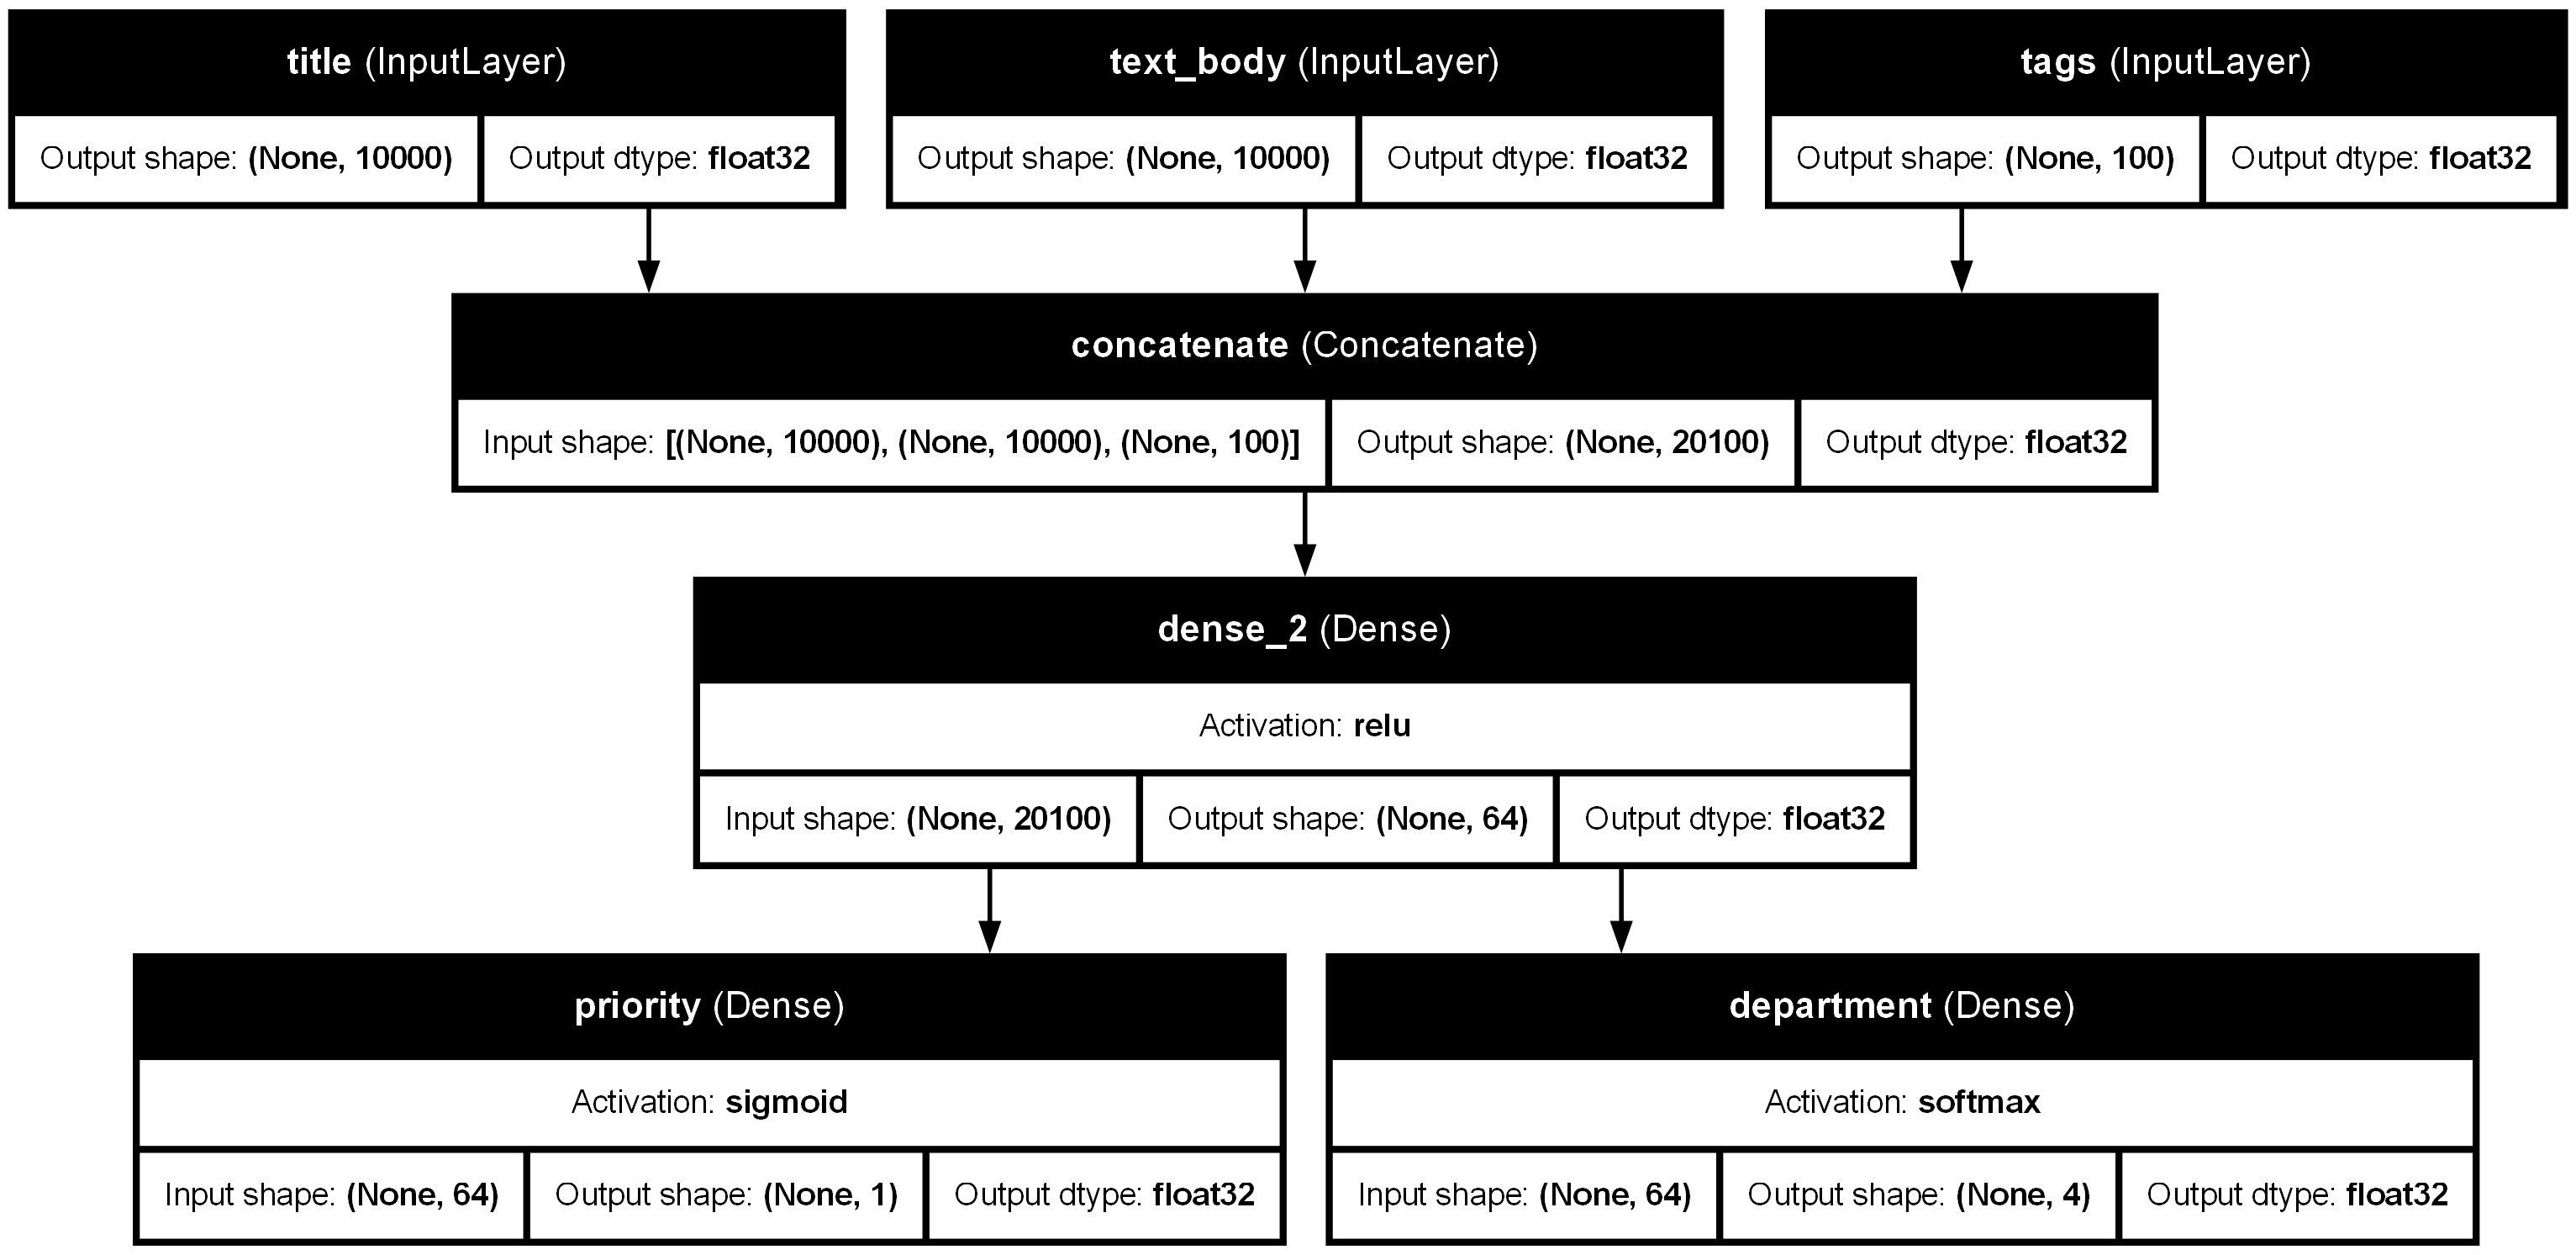

In [10]:
keras.utils.plot_model(model, "ticket_classifier.png",  show_shapes=True, show_layer_names=True, show_dtype=True, show_layer_activations=True)

 #### The “None” in the tensor shapes represents the batch size: this model allows batches of any size.

#### Access to layer connectivity also means that you can inspect and reuse individual nodes (layer calls) in the graph. The model.layers model property provides the list of layers that make up the model, and for each layer you can query layer.input and layer.output

In [11]:
model.layers

[<InputLayer name=title, built=True>,
 <InputLayer name=text_body, built=True>,
 <InputLayer name=tags, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=priority, built=True>,
 <Dense name=department, built=True>]

In [12]:
model.layers[3].input

[<KerasTensor shape=(None, 10000), dtype=float32, sparse=False, ragged=False, name=title>,
 <KerasTensor shape=(None, 10000), dtype=float32, sparse=False, ragged=False, name=text_body>,
 <KerasTensor shape=(None, 100), dtype=float32, sparse=False, ragged=False, name=tags>]

In [13]:
 model.layers[3].output

<KerasTensor shape=(None, 20100), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>

#### This enables you to do feature extraction, creating models that reuse intermediate features from another model.

####  Let’s say you want to add another output to the previous model—you want to estimate how long a given issue ticket will take to resolve, a kind of difficulty rating. You could do this via a classification layer over three categories: “quick,” “medium,” and “difficult.” You don’t need to recreate and retrain a model from scratch. You can start from the intermediate features of your previous model, since you have access to them.

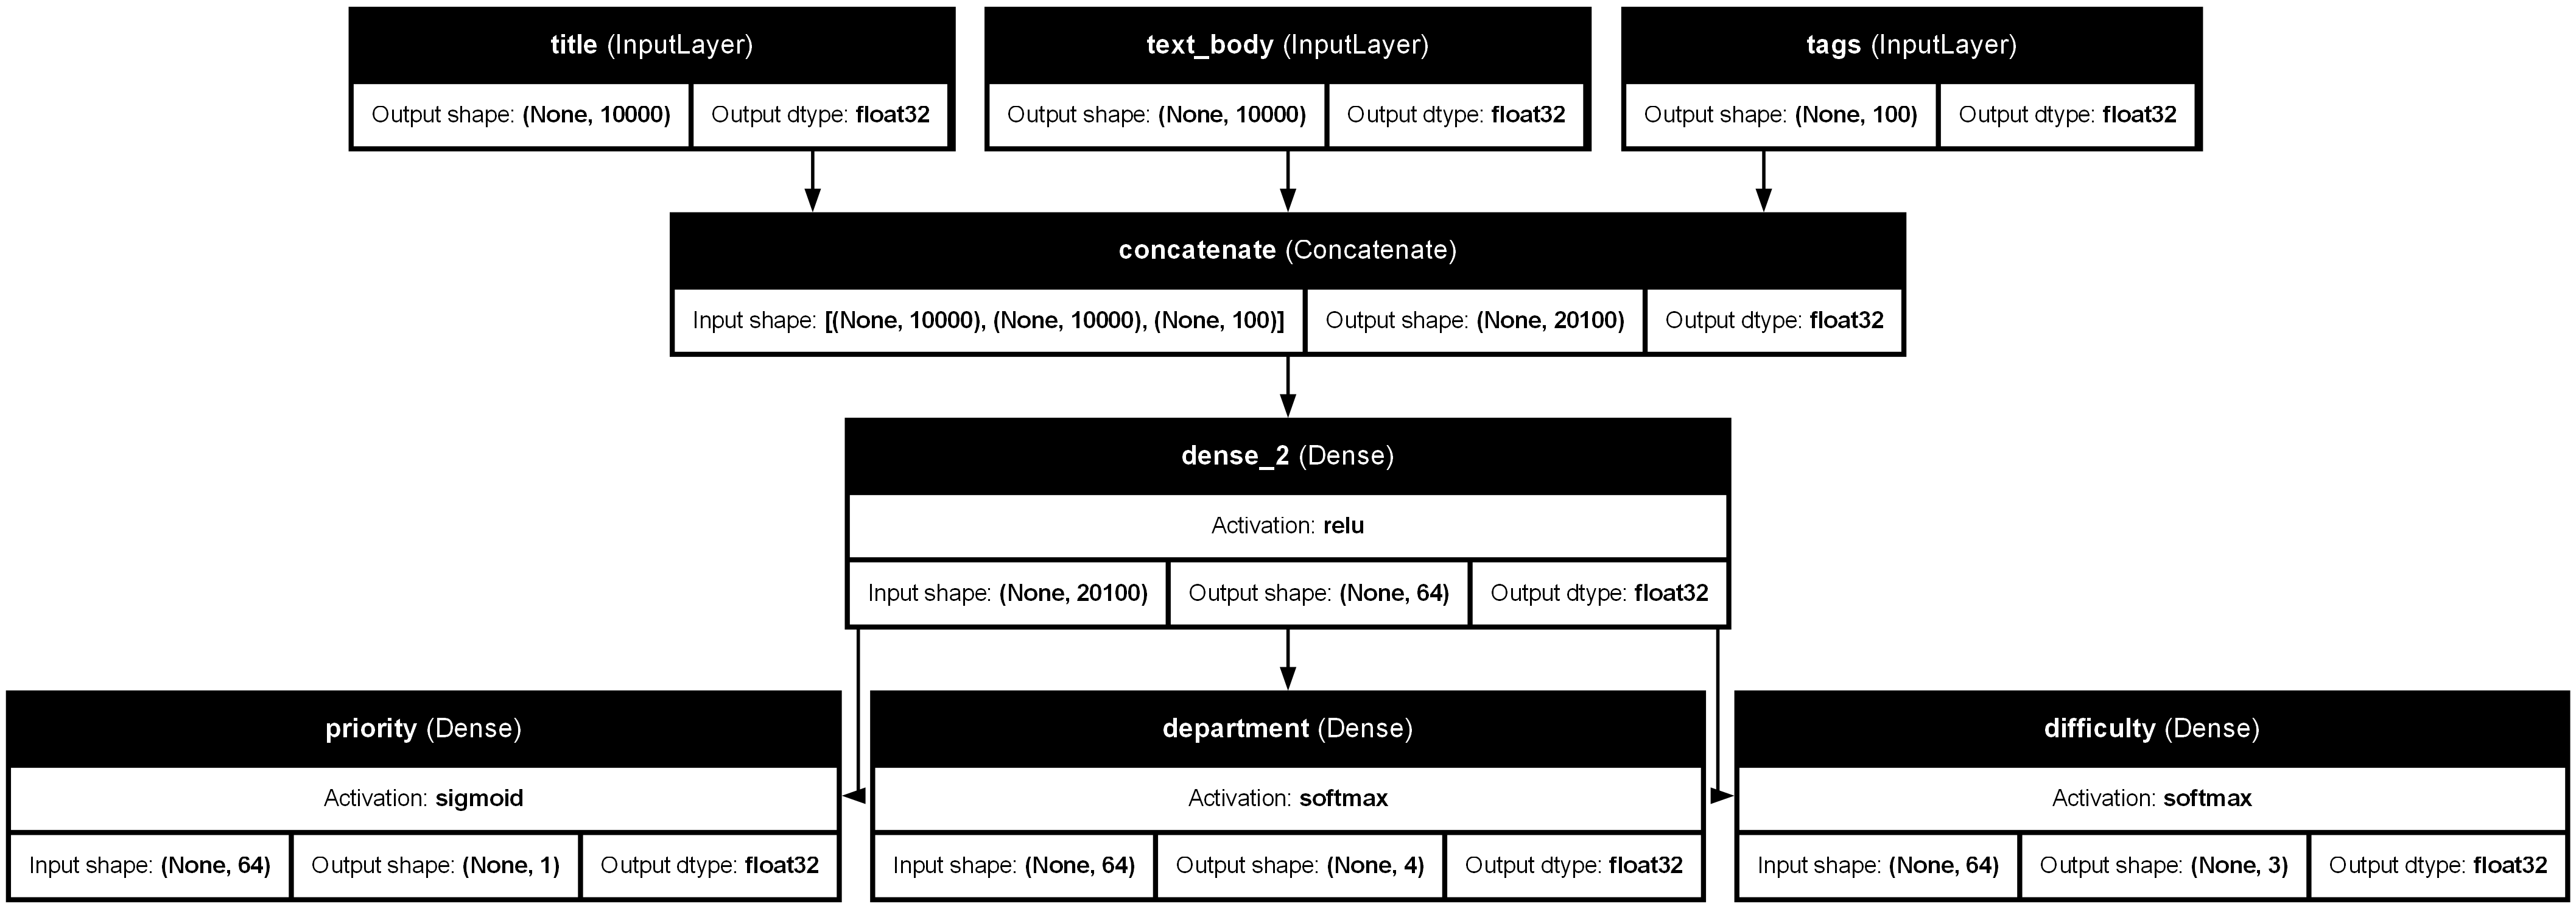

In [15]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)
new_model = keras.Model(
     inputs=[title, text_body, tags],
     outputs=[priority, department, difficulty]
)

keras.utils.plot_model(
    new_model, "updated_ticket_classifier.png", show_shapes=True, show_layer_names=True, show_dtype=True, show_layer_activations=True)

